# An example bimodal model with individual effects
---

## Details

&ensp;AUTHOR:&emsp;   James Foster &emsp; 2025 07 30

MODIFIED:&emsp; James Foster &emsp; 2025 08 01

DESCRIPTION:&emsp; Simulates a bimodal dataset and fits a hierarchical maximum-likelihood von Mises.
Modified from [circular_regression.ipynb](https://github.com/jgraving/unwrap/notebooks/)

            
INPUTS:&emsp;   None
            
OUTPUTS:&emsp;  Plots and test statistics

CHANGES: 
- Defined individual intercepts kappa

REFERENCES:

- Sayin S, ... Graving JM, $et~al$. (2025)
The behavioral mechanisms governing collective motion in swarming locusts.
Science 387,995-1000
DOI:[10.1126/science.adq7832](https://doi.org/10.1126/science.adq7832)

- Graving JM & Foster JJ (in preparation)
Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

---
# TODO
> - Generate dataset
> - Fit bimodal model
> - Fit bimodal model with hierarchical structure
> - Add random intercepts to simulated data
- Set priors for all variables
- Comment in detail

In [215]:
#set up required packages
##JJF make sure to select a conda environment as the kernel!
##JJF to use g++, before running: conda install m2w64-toolchain
##JJF on Mac install "ipywidgets" for Jupyter support of PyMC
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap 

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-5gf61xsn
  Resolved https://github.com/jgraving/unwrap to commit 9567136cb65fe506c37f629d43639bcbb06781c0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11741 sha256=df44f9bf45725156fc31036dafd3cc6902509544717136db48037db9a21ff44d
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-srnovgsl\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-5gf61xsn'


# Simulate data
Using a von Mises distribution, simulate two samples separated by 180°.

In [368]:
import numpy as np
import bambi as bmb
import arviz as az
import pymc as pm
import pandas as pd
import pytensor.tensor as pt
import matplotlib.pyplot as plt

from scipy.stats import vonmises, circmean

from unwrap.link.bambi import LINKS
from unwrap.prior import CircularUniformPrior
from unwrap.data import generate_circular_regression_data
from unwrap.link.numpy import inverse_softplus

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

nsamples = int(20)
nind = int(20)
mnang = np.pi/3
skappa = 200
ikappa = 3.0

npersample = int(np.round(nind*nsamples/2))

data1 = generate_circular_regression_data(
    num_samples= npersample,
    x_range=(0, 0),
    mean_intercept=mnang, #mean at 60°
    mean_slope=0,
    conc_intercept= (skappa), #highly concentrated
    conc_slope=0,
    mean_link="shifted_modulo",
    conc_link="softplus",
)
#comes out less concentrated?
data2 = generate_circular_regression_data(
    num_samples= npersample,
    x_range=(0, 0),
    mean_intercept=mnang + np.pi, #mean at 240°
    mean_slope=0,
    conc_intercept=(skappa), #highly concentrated
    conc_slope=0,
    mean_link="shifted_modulo",
    conc_link="softplus",
)

data = pd.concat([data1, data2],    ignore_index= True) 
# data = pd.concat([data2, data1],    ignore_index= True) 
data.reset_index(drop=True)
ids = [chr(i) for  i in range(97, 97+nind)] #97 is 'a', 123 is 'z'
ids = pd.Series( np.repeat( [ids], nsamples, axis = 0 ).flatten()  )
trl = np.repeat( range(0, nsamples), nind) #replicate trial numbers 1-20
trl = np.sort( trl ) #organise from trial 1 to trial 20
df = pd.DataFrame(
    {
        "angles": pd.Series(data['y']) ,
         "Individual": ids,
         'Trial': trl +1
    }, 
)
# print(df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

Sampling: [x, y]
Sampling: [x, y]


       angles Individual  Trial
0    1.064218          a      1
1    1.067194          b      1
2    1.107656          c      1
3    1.048818          d      1
4    1.065488          e      1
5    1.137755          f      1
6    1.009386          g      1
7    1.148547          h      1
8    0.918179          i      1
9    1.062518          j      1
10   1.008636          k      1
11   0.974635          l      1
12   1.160676          m      1
13   0.963739          n      1
14   1.042576          o      1
15   0.997615          p      1
16   0.946508          q      1
17   1.055175          r      1
18   1.024824          s      1
19   1.107654          t      1
20   0.982083          a      2
21   0.911538          b      2
22   0.959478          c      2
23   1.076941          d      2
24   1.073631          e      2
25   1.267513          f      2
26   0.928332          g      2
27   1.104135          h      2
28   1.079348          i      2
29   1.057259          j      2
30   1.1

## Add individual intercepts
Sample individual intercepts drawn from a less concentrated von Mises distribution. These are the added to each sample belonging to each individual. In this case, each individual's headings are more highly correlated than headings compared across individuals, as is common in real data.

In [369]:
from unwrap.link.numpy import shifted_modulo
#add individual intercepts
intercept_id = generate_circular_regression_data(
    num_samples=ids.nunique(),
    x_range=(0, 0),
    mean_intercept=0, #mean at 0°
    mean_slope=0,
    conc_intercept=(ikappa), # very weakly concentrated
    conc_slope=0,
    mean_link="shifted_modulo",
    conc_link="softplus",
)
intercept_id['Individual'] = [chr(i) for  i in range(97, 97+nind)] #97 is 'a', 123 is 'z'
print(intercept_id)
dfm = pd.merge(left = df, right = intercept_id, on = 'Individual')
# print(dfm)
dfm['RadAngle'] = dfm['angles'] + dfm['y']
dfm['RadAngle'] = dfm['RadAngle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)
df = dfm
print(df)

Sampling: [x, y]


      x         y  mean  concentration Individual
0   0.0  0.137190   0.0       3.048587          a
1   0.0  0.161085   0.0       3.048587          b
2   0.0  0.478850   0.0       3.048587          c
3   0.0  0.013082   0.0       3.048587          d
4   0.0  0.147387   0.0       3.048587          e
5   0.0  1.752058   0.0       3.048587          f
6   0.0  0.122697   0.0       3.048587          g
7   0.0  1.323280   0.0       3.048587          h
8   0.0  0.068449   0.0       3.048587          i
9   0.0  0.923542   0.0       3.048587          j
10  0.0 -0.961382   0.0       3.048587          k
11  0.0  0.123524   0.0       3.048587          l
12  0.0 -0.308857   0.0       3.048587          m
13  0.0 -0.570079   0.0       3.048587          n
14  0.0  0.859853   0.0       3.048587          o
15  0.0 -0.650209   0.0       3.048587          p
16  0.0 -0.037305   0.0       3.048587          q
17  0.0 -0.395125   0.0       3.048587          r
18  0.0 -0.772647   0.0       3.048587          s


## Plot data

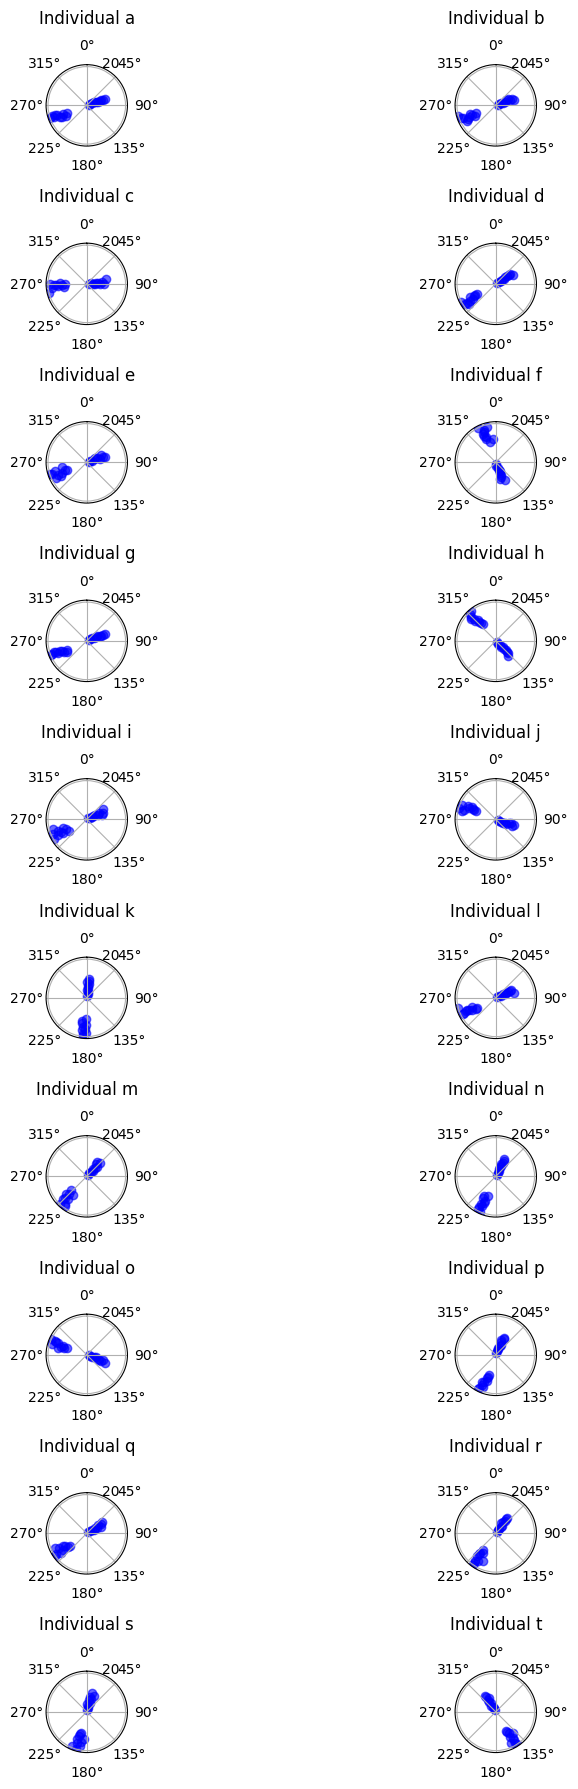

In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Get unique individual Individuals.
unique_individuals = df['Individual'].unique()
# sample_individuals = unique_individuals[np.random.randint(low = 0, high=10, size=6)] # just six chosen randomly
sample_individuals = unique_individuals # all chosen randomly

# Create a grid of polar subplots.
n_plots = len(sample_individuals)
n_rows, n_cols = ( np.intc(np.ceil(n_plots/2)) , 2  ) # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 20  # Maximum radial value (maximum runs)  # Maximum radial value

# print(df[df['Individual'] == 'a'])

# Plot for each individual.
for idx, individual in enumerate(sample_individuals):
    ax = axes[idx]
    # Set axes to geographic format (clockwise, 0° at the top)
    ax.set_theta_zero_location('N')#place 0° at the top
    ax.set_theta_direction(-1)#reverse to clockwise

    individual_data = df[df['Individual'] == individual]
    # print(individual_data.head())
    plotcol = 'blue'        
    plot_scatter(ax, individual_data, 'RadAngle', 'Trial', 
                 plotcol, individual_data)
    #Add expected axis for 2nd trial
    ax.plot(individual_data['RadAngle'].values[0]+[-np.pi, np.pi], [radial_max, radial_max], color='orange', linewidth=1)
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)


plt.tight_layout()
plt.show()


# Doubled angles model

In [ ]:
#Doubled angles model
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.link.numpy import shifted_modulo
from unwrap.prior import CircularUniformPrior
# from unwrap.distributions import BimodalVonMises
from pymc import VonMises

from scipy.stats import vonmises, circstd

#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: 
                                    shifted_modulo(x*2) if pd.notnull(x) else x)
vm_prior = vonmises.fit(df["TwoAngle"], fscale=1) 
sd_prior = circstd(df["TwoAngle"]) #Mardia SD used

# Define the model formula with updated, capitalized variable names
formula = bmb.Formula(
    "TwoAngle ~ 1 + (1|Individual)",
    "kappa ~ 1 + (1|Individual)",
)
priors = {
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=15*np.pi/180),#relatively tight
# Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
"1|Individual": bmb.Prior(
# "Normal", mu=0, sigma= bmb.Prior('HalfStudentT', nu = 3, sigma=sd_prior) #assume the ML estimate is correct
"Normal", mu=0, sigma= bmb.Prior('HalfStudentT', nu = 3, sigma=10*np.pi/180) #assume very small (kappa ~ Inf)
),
# Priors for the κ-model (inside the "kappa" dictionary):
"kappa": {
    # Fixed effects for κ:
    "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
    # Individual-level effects for κ:
    "1|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are smal
    ),
},
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(model)

# Fit the model.
# 4000 iterations takes approx 30s
idata = model.fit(tune = 1000,
                  draws= 1000,
                  init = 'auto',
                  progressbar=True) # 

       Formula: TwoAngle ~ 1 + (1|Individual)
                kappa ~ 1 + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.9728, sigma: 0.2618)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.1745))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check heuristics

In [328]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    ]
)
#NB TwoAngle mean should be around 60°x2 = 120° = 2.09
# Individual sigma can be converted to an estimate of kappa with A1inv(exp(((sigma/2)^2)/-2))
# This appears a good estimate of kappa (slight underestimate of sigma)
# Needs a tight prior to avoid interfering with pop intecept

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.993,0.230,1.574,2.425,0.040,0.036,22.0,105.0,1.13
1|Individual_sigma,1.452,0.236,1.052,1.906,0.009,0.006,690.0,1724.0,1.02
kappa_Intercept,17.255,0.779,15.832,18.741,0.006,0.004,16041.0,5493.0,1.00
kappa_1|Individual_sigma,0.505,0.051,0.409,0.599,0.000,0.000,13145.0,5812.0,1.00


## Plot chains

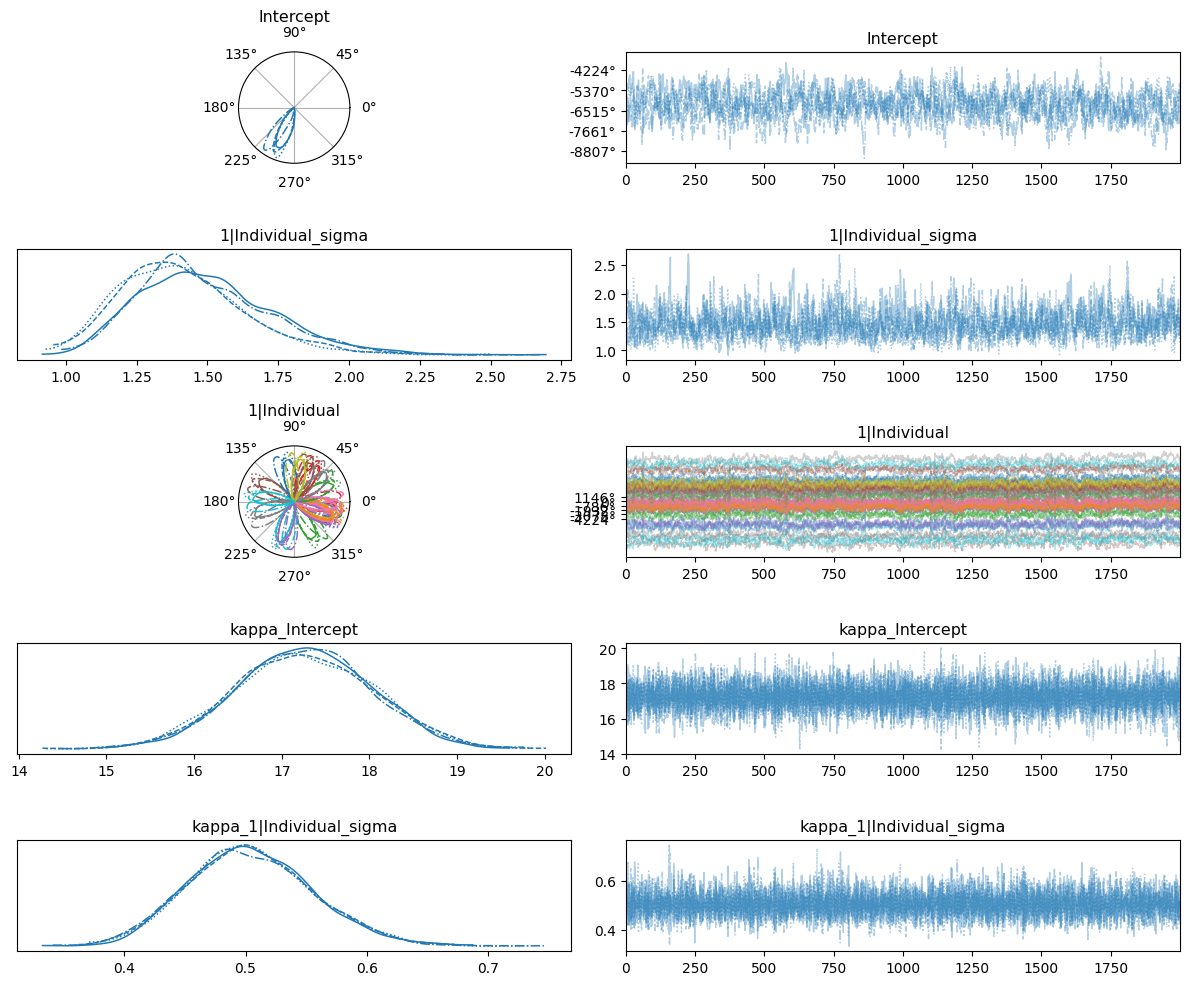

In [329]:
varnms = ["Intercept",
               "1|Individual_sigma",
               "1|Individual",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
cvars = ["Intercept",
        "1|Individual",
        ]
#transform the circular data for interpretability
idata_trans = idata.copy() # set up a variable for transformed data
for cvar in cvars:
    idata_trans.posterior[cvar] = -180*idata_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_trans,
              var_names=varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()
#The restrictive prior on population mean biases the estimate (137°) towards
#the MLE estimate of grand mean (138°), but not the true mean (60°*2 = 120°).

# Full bimodal model

In [ ]:
from unwrap.link.numpy import inverse_softplus
#build pymc model equivalent to Sayin et al.
## my comments are labelled like this
# Define the data based on merged_df

## prepare the data
#vector of angles for pymc
directions = df['RadAngle'].values

## convert from names to numbers
# individuals = df['Individual'].values.astype(np.int32)
individuals, uniques = pd.factorize(df['Individual'])#returns the index in the unique values vector, and the unique values vector
## pymc will only accept integers, convert tuple to integer entrywise
individuals = pd.Series(individuals).apply(lambda x: np.int32(x))
num_individuals = df['Individual'].nunique()

# Define the model
## currently uses same priors as Sayin et al., only the mean has a more specific prior and kappa has a less restrictive one
with pm.Model() as hierarchical_directional_model:

    # Population mean angle in radians, bounded between -π and π
    ## set up a pair of angles
    # mu_pop_unsorted = pm.Uniform("mu_pop_unsorted", lower=-np.pi, upper=np.pi, shape=(2,))
    ## pymc has trouble finding this on its own, giving a better prior
    ## originally this was a pair of values anywhere on the circle
    ## this is now a pair of values 180° apart, drawn from a normal distribution
    ## roughly centred on the grand mean from the doubled angles
    mu_pop_unsorted = pm.Normal("mu_pop_unsorted", mu=vm_prior[1]/2 + [0, np.pi], sigma = 30*np.pi/180, shape=(2,))
    mu_pop = pm.Deterministic("mu_pop", pt.sort(mu_pop_unsorted))

    # Individual mean angles with a Von Mises distribution, adjusted by the population mean
    mu_unsorted = pm.VonMises("mu_unsorted", 
                              mu=0, 
                              kappa=20, 
                              shape=(num_individuals, 2)
                              ) + mu_pop_unsorted #broadcast to the same shape through addition
    mu = pm.Deterministic("mu", pt.sort(mu_unsorted))

    # Population kappa values with a softplus transformation for non-negativity
    # kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(2.0), sigma=0.5, shape=(2,))
    # pymc less restrictive prior
    kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(2.0), sigma=1.0, shape=(2,))
    kappa_pop = pm.Deterministic("kappa_pop", pt.softplus(kappa_log_pop))

    # Individual kappa values, also transformed for non-negativity
    kappa_log = pm.Normal("kappa_log", mu=0, sigma=0.5, shape=(num_individuals, 2)) + kappa_log_pop
    kappa = pm.Deterministic("kappa", pt.softplus(kappa_log))

    # Population weights with a sigmoid transformation
    weights_logit_pop = pm.Normal("weights_logit_pop", mu=0, sigma=0.5)
    weights_pop = pm.Deterministic("weights_pop", pm.math.sigmoid(pt.stack([weights_logit_pop, -weights_logit_pop], axis=-1)))

    # Individual weights, also transformed with a sigmoid function
    weights_logit = pm.Normal("weights_logit", mu=0, sigma=1.0, shape=(num_individuals,)) + weights_logit_pop
    weights = pm.Deterministic("weights", pm.math.sigmoid(pt.stack([weights_logit, -weights_logit], axis=-1)))

    # Von Mises components for mixture model
    components = pm.VonMises.dist(mu=mu[individuals], kappa=kappa[individuals])

    # Mixture model for observed data (directions)
    pm.Mixture("directions_obs", w=weights[individuals], comp_dists=components, observed=directions)

In [339]:
#takes over one minute to initialise
#less than 20s to sample
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    with hierarchical_directional_model:
        trace = pm.sample(tune = 1000,
                            draws = 500, 
                            return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_unsorted, mu_unsorted, kappa_log_pop, kappa_log, weights_logit_pop, weights_logit]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [340]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    trace, 
    var_names=["mu_pop_unsorted",
            #    "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
                "kappa_log_pop",
            #    "kappa_log",
               "weights_logit_pop",
            #    "weights_logit"
                ],
    circ_var_names=["mu_pop_unsorted",
                    # "mu_unsorted"
                    ]
)
#NB mean should be around 60° = 1.05

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pop_unsorted[0],0.863,0.132,0.594,1.037,0.047,0.045,7.0,45.0,1.53
mu_pop_unsorted[1],-2.275,0.134,-2.545,-2.091,0.047,0.045,7.0,31.0,1.53
kappa_log_pop[0],9.818,0.738,8.333,11.089,0.014,0.010,2646.0,1737.0,1.00
kappa_log_pop[1],9.820,0.754,8.438,11.264,0.013,0.009,3386.0,1661.0,1.00
weights_logit_pop,0.006,0.231,-0.407,0.430,0.006,0.005,1273.0,1448.0,1.00


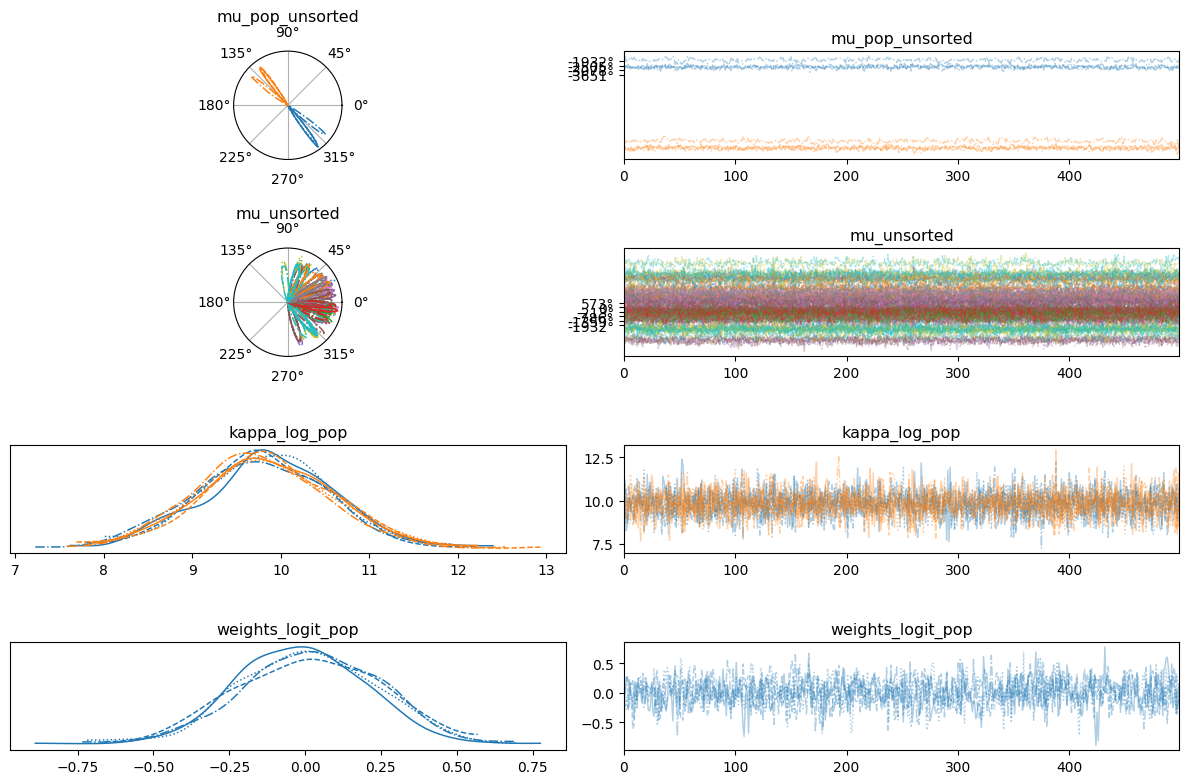

In [341]:
varnms = ["mu_pop_unsorted",
               "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
                "kappa_log_pop",
            #    "kappa_log",
               "weights_logit_pop",
            #    "weights_logit"
                ]
#Specify which parameters are circular
cvars = ["mu_pop_unsorted",
                    "mu_unsorted"
                    ]
#transform the circular data for interpretability
trace_trans = trace.copy() # set up a variable for transformed data
for cvar in cvars:
    trace_trans.posterior[cvar] = -180*trace_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(trace_trans,
              var_names=varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Full bimodal model with individual effects hyperparameter

In [413]:
from unwrap.link.numpy import inverse_softplus
#build pymc model with hyperparameter for individual variance
# Define the data based on merged_df
#vector of angles for pymc
directions = df['angles'].values

#convert from names to numbers
# individuals = df['Individual'].values.astype(np.int32)
individuals, uniques = pd.factorize(df['Individual'])#returns the index in the unique values vector, and the unique values vector
#pymc will only accept integers, convert tuple to integer entrywise
individuals = pd.Series(individuals).apply(lambda x: np.int32(x))
num_individuals = df['Individual'].nunique()

# Define the model
#currently uses same priors as Sayin et al., only the mean has a more specific prior and kappa has a less restrictive one
with pm.Model() as hyper_directional_model:

    # Population mean angle in radians, bounded between -π and π
    mu_pop_unsorted = pm.Uniform("mu_pop_unsorted", lower=-np.pi, upper=np.pi, shape=(2,))
    # pymc has trouble finding this on its own, giving a better prior
        # mu_pop_unsorted = pm.Normal("mu_pop_unsorted", 
        #                             mu = [mnang, mnang+np.pi], 
        #                             # mu=vm_prior[1]/2 + [0, np.pi], 
        #                             # sigma = 15*np.pi/180, 
        #                             sigma = 1*np.pi/180, 
        #                             shape=(2,))
    mu_pop = pm.Deterministic("mu_pop", pt.sort(mu_pop_unsorted))

    #try a low pop kappa, avoid bias to large values
    mu_kappa_log = pm.Normal('mu_kappa_log', mu = inverse_softplus(0.001), sigma = 0.1, shape = (2,))
    mu_kappa = pm.Deterministic('mu_kappa', pt.softplus(mu_kappa_log))
    
    # Individual mean angles with a Von Mises distribution, adjusted by the population mean
    #however low mu_kappa is, these are not varying
    mu_unsorted = pm.VonMises("mu_unsorted", 
                                mu=[0], 
                                kappa=mu_kappa, 
                                shape=(num_individuals, 2)
                                ) + mu_pop_unsorted #broadcast to the same shape through addition
    mu = pm.Deterministic("mu", pt.sort(mu_unsorted))
        # id_components = pm.VonMises.dist(mu=[0, np.pi], kappa= mu_kappa)
        # # Population weights with a sigmoid transformation
        # id_weights_logit = pm.Normal("id_weights_logit", mu=0, sigma=0.5)
        # id_weights = pm.Deterministic("id_weights", pm.math.sigmoid(pt.stack([id_weights_logit, -id_weights_logit], axis=-1)))

        # mu_unsorted = pm.Mixture("mu_unsorted", 
        #                             w=id_weights,
        #                             comp_dists=id_components,
        #                             shape=(num_individuals, 2)
        #                             ) + mu_pop_unsorted #broadcast to the same shape through addition
        # mu = pm.Deterministic("mu", pt.sort(mu_unsorted))
                # #Normally distributed version
                # # mu_sigma = pm.HalfStudentT("mu_sigma", nu = 3, sigma = 90*np.pi/180)
                # mu_sigma = pm.Lognormal("mu_sigma", mu = np.log(15*np.pi/180), sigma = 0.5)
                # # mu_sigma = pm.Lognormal("mu_sigma", mu = np.log(sd_prior/2), sigma = 0.1)
                # mu_unsorted = pm.Normal('mu_unsorted',
                #                         mu = [0, np.pi], 
                #                         sigma = mu_sigma,
                #                         shape = (num_individuals, 2)
                #                         ) + mu_pop_unsorted
                # mu = pm.Deterministic("mu", pt.sort(mu_unsorted))

    # Population kappa values with a softplus transformation for non-negativity
    # kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(2.0), sigma=0.5, shape=(2,))
    # pymc less restrictive prior
    # kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(0.1), sigma=1.0, shape=(2,))
    #expectation of high agreement across individuals
    kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(100), sigma = 1.0, shape=(2,))
    #is this in fact individual kappa?
    kappa_pop = pm.Deterministic("kappa_pop", pt.softplus(kappa_log_pop))

    # Individual kappa values, also transformed for non-negativity
    kappa_log = pm.Normal("kappa_log", mu=0, sigma=0.5, shape=(num_individuals, 2)) + kappa_log_pop
    kappa = pm.Deterministic("kappa", pt.softplus(kappa_log))

    # Population weights with a sigmoid transformation
    weights_logit_pop = pm.Normal("weights_logit_pop", mu=0, sigma=0.5)
    weights_pop = pm.Deterministic("weights_pop", pm.math.sigmoid(pt.stack([weights_logit_pop, -weights_logit_pop], axis=-1)))

    # Individual weights, also transformed with a sigmoid function
    weights_logit = pm.Normal("weights_logit", mu=0, sigma=1.0, shape=(num_individuals,)) + weights_logit_pop
    weights = pm.Deterministic("weights", pm.math.sigmoid(pt.stack([weights_logit, -weights_logit], axis=-1)))

    # Von Mises components for mixture model
    components = pm.VonMises.dist(mu=mu[individuals], kappa=kappa[individuals])

    # Mixture model for observed data (directions)
    pm.Mixture("directions_obs", w=weights[individuals], comp_dists=components, observed=directions)

In [ ]:
#takes over one minute to initialise
#less than 20s to sample
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    with hyper_directional_model:
        trace_hyper = pm.sample(tune = 1000,
                                draws = 300, 
                                return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_unsorted, mu_kappa_log, mu_unsorted, kappa_log_pop, kappa_log, weights_logit_pop, weights_logit]


Output()

In [ ]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    trace_hyper, 
    var_names=["mu_pop_unsorted",
            #    "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
               "mu_kappa",#
            #    "mu_sigma",#
                "kappa_pop",
            #    "kappa_log",
               "weights_logit_pop",
            #    "weights_logit"
                ],
    circ_var_names=["mu_pop_unsorted",
                    # "mu_unsorted"
                    ]
)
#NB mean should be around 60° = 1.05
#mu_kappa is overestimated here, but that may be reasonable with limited data
#kappa_pop is overestimated here, but that may be reasonable with limited data

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pop_unsorted[0],0.920,0.116,0.716,1.150,0.005,0.004,398.0,621.0,1.01
mu_pop_unsorted[1],-2.217,0.106,-2.419,-2.025,0.006,0.004,389.0,665.0,1.00
mu_kappa[0],7.319,1.749,4.183,10.444,0.036,0.025,2382.0,1668.0,1.00
mu_kappa[1],7.400,1.735,3.933,10.423,0.038,0.027,2046.0,1305.0,1.00
kappa_pop[0],15.288,1.499,12.467,18.198,0.023,0.017,4146.0,1318.0,1.00
kappa_pop[1],15.255,1.486,12.518,18.044,0.022,0.016,4463.0,1512.0,1.00
weights_logit_pop,0.000,0.285,-0.524,0.552,0.009,0.007,956.0,1454.0,1.00


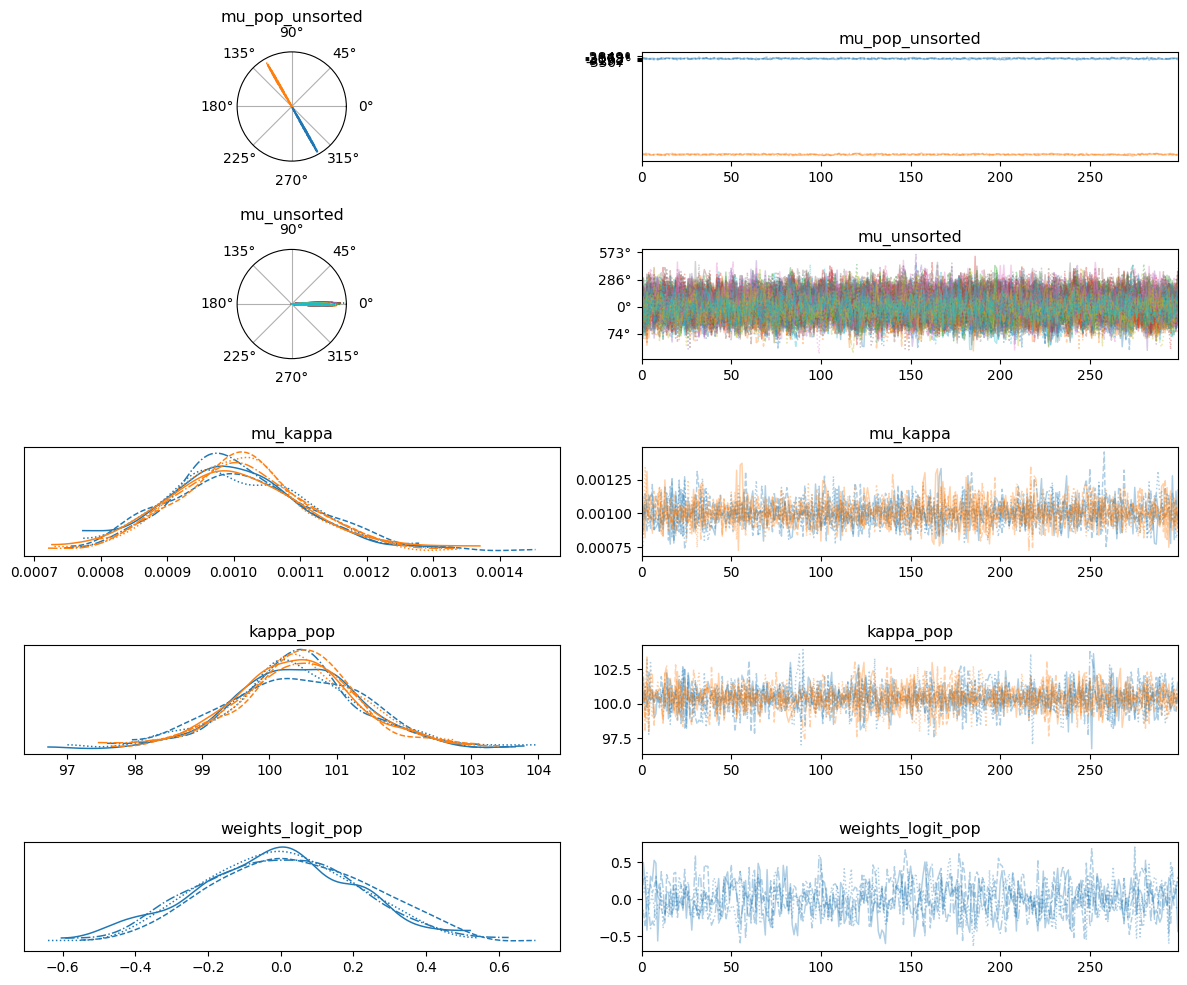

In [412]:
varnms = ["mu_pop_unsorted",
               "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
               "mu_kappa",
            #    "mu_sigma",
                "kappa_pop",
            #    "kappa_log",
               "weights_logit_pop",
            #    "weights_logit"
                ]
#Specify which parameters are circular
cvars = ["mu_pop_unsorted",
         "mu_unsorted"
        ]
#transform the circular data for interpretability
trace_hyper_trans = trace_hyper.copy() # set up a variable for transformed data
for cvar in cvars:
    trace_hyper_trans.posterior[cvar] = -180*trace_hyper_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(trace_hyper_trans,
              var_names= varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()